# ECE 420 – Lab 4: Pitch Detection

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read

MIN_PITCH = 80
MAX_PITCH = 400
ENERGY_THRESHOLD = 1e7


## Part 1 – Voiced vs Unvoiced

In [9]:
def calculate_energy(frame):
    return np.sum(frame**2)

def is_voiced(frame, threshold=ENERGY_THRESHOLD):
    return calculate_energy(frame) > threshold


**Q1:** How do we decide if a frame is voiced?  
**A1:** Check if frame energy > threshold → voiced, else unvoiced.

## Part 2 – Autocorrelation

In [10]:
def autocorrelation_fft(sig):
    N = len(sig)
    padded = np.concatenate([sig, np.zeros(N)])
    fft_sig = np.fft.fft(padded)
    psd = fft_sig * np.conj(fft_sig)
    ac = np.real(np.fft.ifft(psd))
    return ac[:N]

def estimate_pitch(ac, Fs, min_f=MIN_PITCH, max_f=MAX_PITCH):
    min_lag = int(Fs / max_f)
    max_lag = int(Fs / min_f)
    search = ac[min_lag:max_lag]
    if len(search) == 0:
        return -1
    lag = min_lag + np.argmax(search)
    return Fs / lag


**Q2:** Why is autocorrelation useful?  
**A2:** It reveals the lag where a signal repeats → fundamental frequency.

In [11]:
def process_frame(frame, Fs):
    if not is_voiced(frame):
        return -1
    ac = autocorrelation_fft(frame)
    return estimate_pitch(ac, Fs)


**Q3:** The autocorrelation has many peaks. Which one is correct?  
**A3:** The first strong peak after lag=0 (fundamental, not harmonics).  


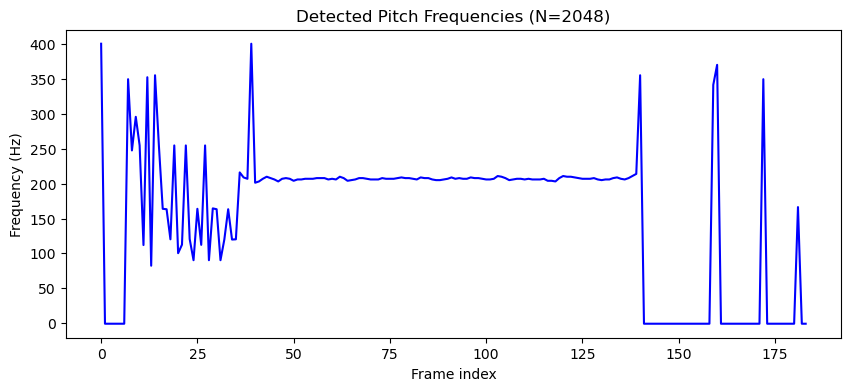

In [13]:
Fs, data = read("test_vector.wav")
if data.ndim > 1:
    data = data[:,0]
data = data.astype(float)

FRAME_SIZE = 2048
num_frames = len(data) // FRAME_SIZE
freqs = np.zeros(num_frames)

for i in range(num_frames):
    frame = data[i*FRAME_SIZE:(i+1)*FRAME_SIZE]
    freqs[i] = process_frame(frame, Fs)

plt.figure(figsize=(10,4))
plt.plot(freqs, 'b')
plt.title("Detected Pitch Frequencies (N=2048)")
plt.xlabel("Frame index")
plt.ylabel("Frequency (Hz)")
plt.show()


**Q4:** Why did we use 40 ms frames (2048 samples)?  
**A4:** Enough resolution to detect low pitches (80 Hz), but still short enough to follow speech changes.  

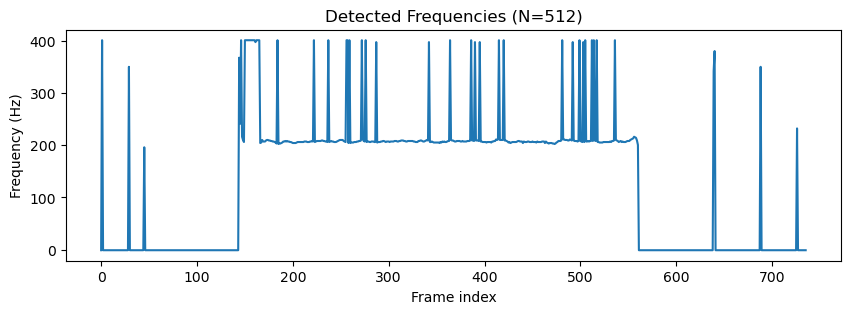

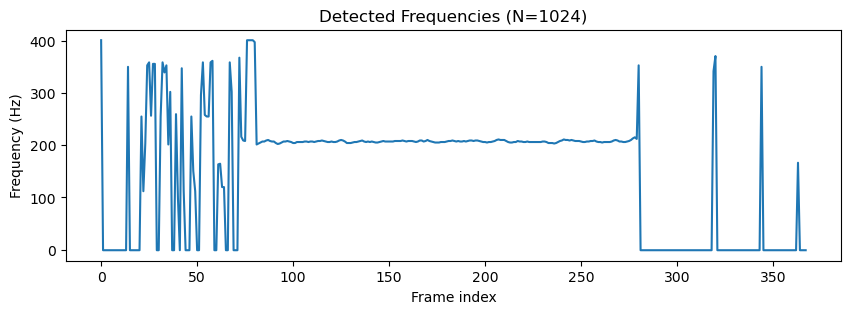

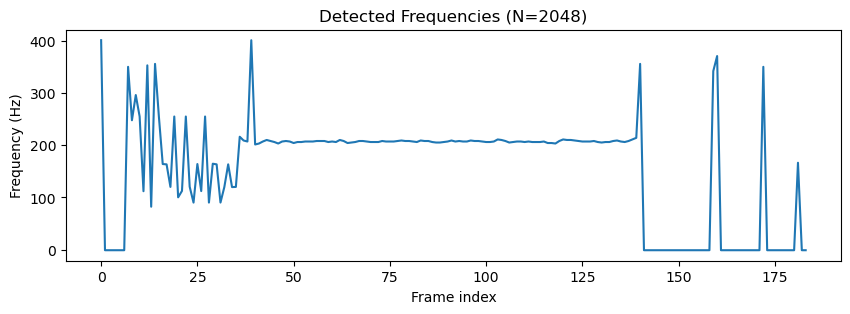

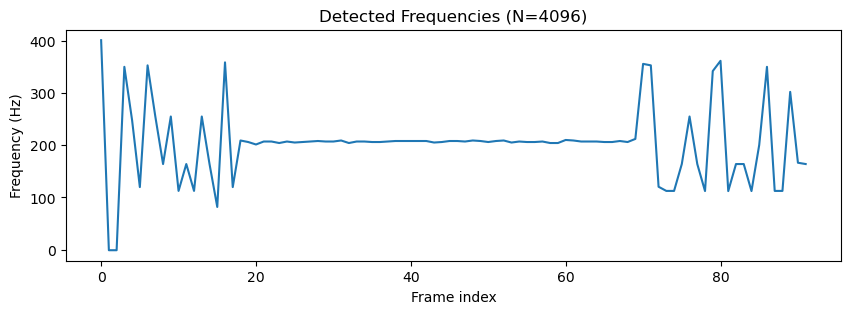

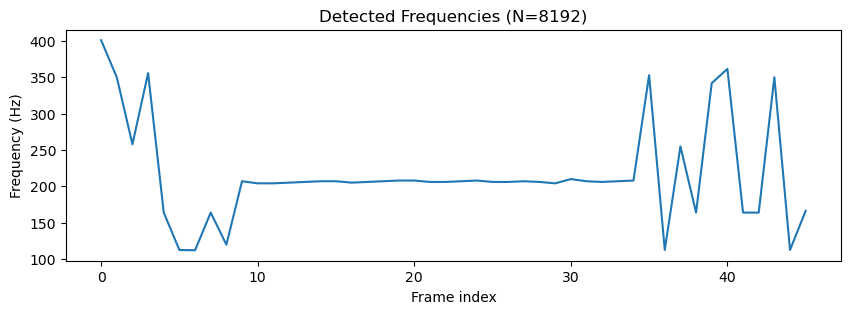

In [15]:
frame_sizes = [512, 1024, 2048, 4096, 8192]

for N in frame_sizes:
    num_frames = len(data) // N
    freqs = np.zeros(num_frames)
    for i in range(num_frames):
        frame = data[i*N:(i+1)*N]
        freqs[i] = process_frame(frame, Fs)
    plt.figure(figsize=(10,3))
    plt.plot(freqs)
    plt.title(f"Detected Frequencies (N={N})")
    plt.xlabel("Frame index")
    plt.ylabel("Frequency (Hz)")
    plt.show()


**Q5:** What happens when we change frame size N?  
**A5:** Larger N → better frequency resolution, but worse time resolution. Smaller N → track fast changes, but lose accuracy for low pitches.  